In [1]:
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

In [2]:
# Create the rational expectation version of Cagan model in finite time
CaganREE = namedtuple("CaganREE", 
                        ["m0",    # initial money supply
                         "μ_seq", # sequence of rate of growth
                         "α",     # sensitivity parameter
                         "δ",     # α/(1 + α)
                         "π_end"  # terminal expected inflation
                        ])

def create_cagan_model(m0=1, α=5, μ_seq=None):
    δ = α/(1 + α)
    π_end = μ_seq[-1]    # compute terminal expected inflation
    return CaganREE(m0, μ_seq, α, δ, π_end)

In [3]:
def solve(model, T):
    m0, π_end, μ_seq, α, δ = (model.m0, model.π_end, 
                              model.μ_seq, model.α, model.δ)
    
    # Create matrix representation above
    A1 = np.eye(T+1, T+1) - δ * np.eye(T+1, T+1, k=1)
    A2 = np.eye(T+1, T+1) - np.eye(T+1, T+1, k=-1)

    b1 = (1-δ) * μ_seq + np.concatenate([np.zeros(T), [δ * π_end]])
    b2 = μ_seq + np.concatenate([[m0], np.zeros(T)])

    π_seq = np.linalg.solve(A1, b1)
    m_seq = np.linalg.solve(A2, b2)

    π_seq = np.append(π_seq, π_end)
    m_seq = np.append(m0, m_seq)

    p_seq = m_seq + α * π_seq

    return π_seq, m_seq, p_seq

In [4]:
T1 = 60
μ0 = 0.5
μ_star = 0
T = 80

μ_seq_1 = np.append(μ0*np.ones(T1+1), μ_star*np.ones(T-T1))

cm = create_cagan_model(μ_seq=μ_seq_1)

# solve the model
π_seq_1, m_seq_1, p_seq_1 = solve(cm, T)

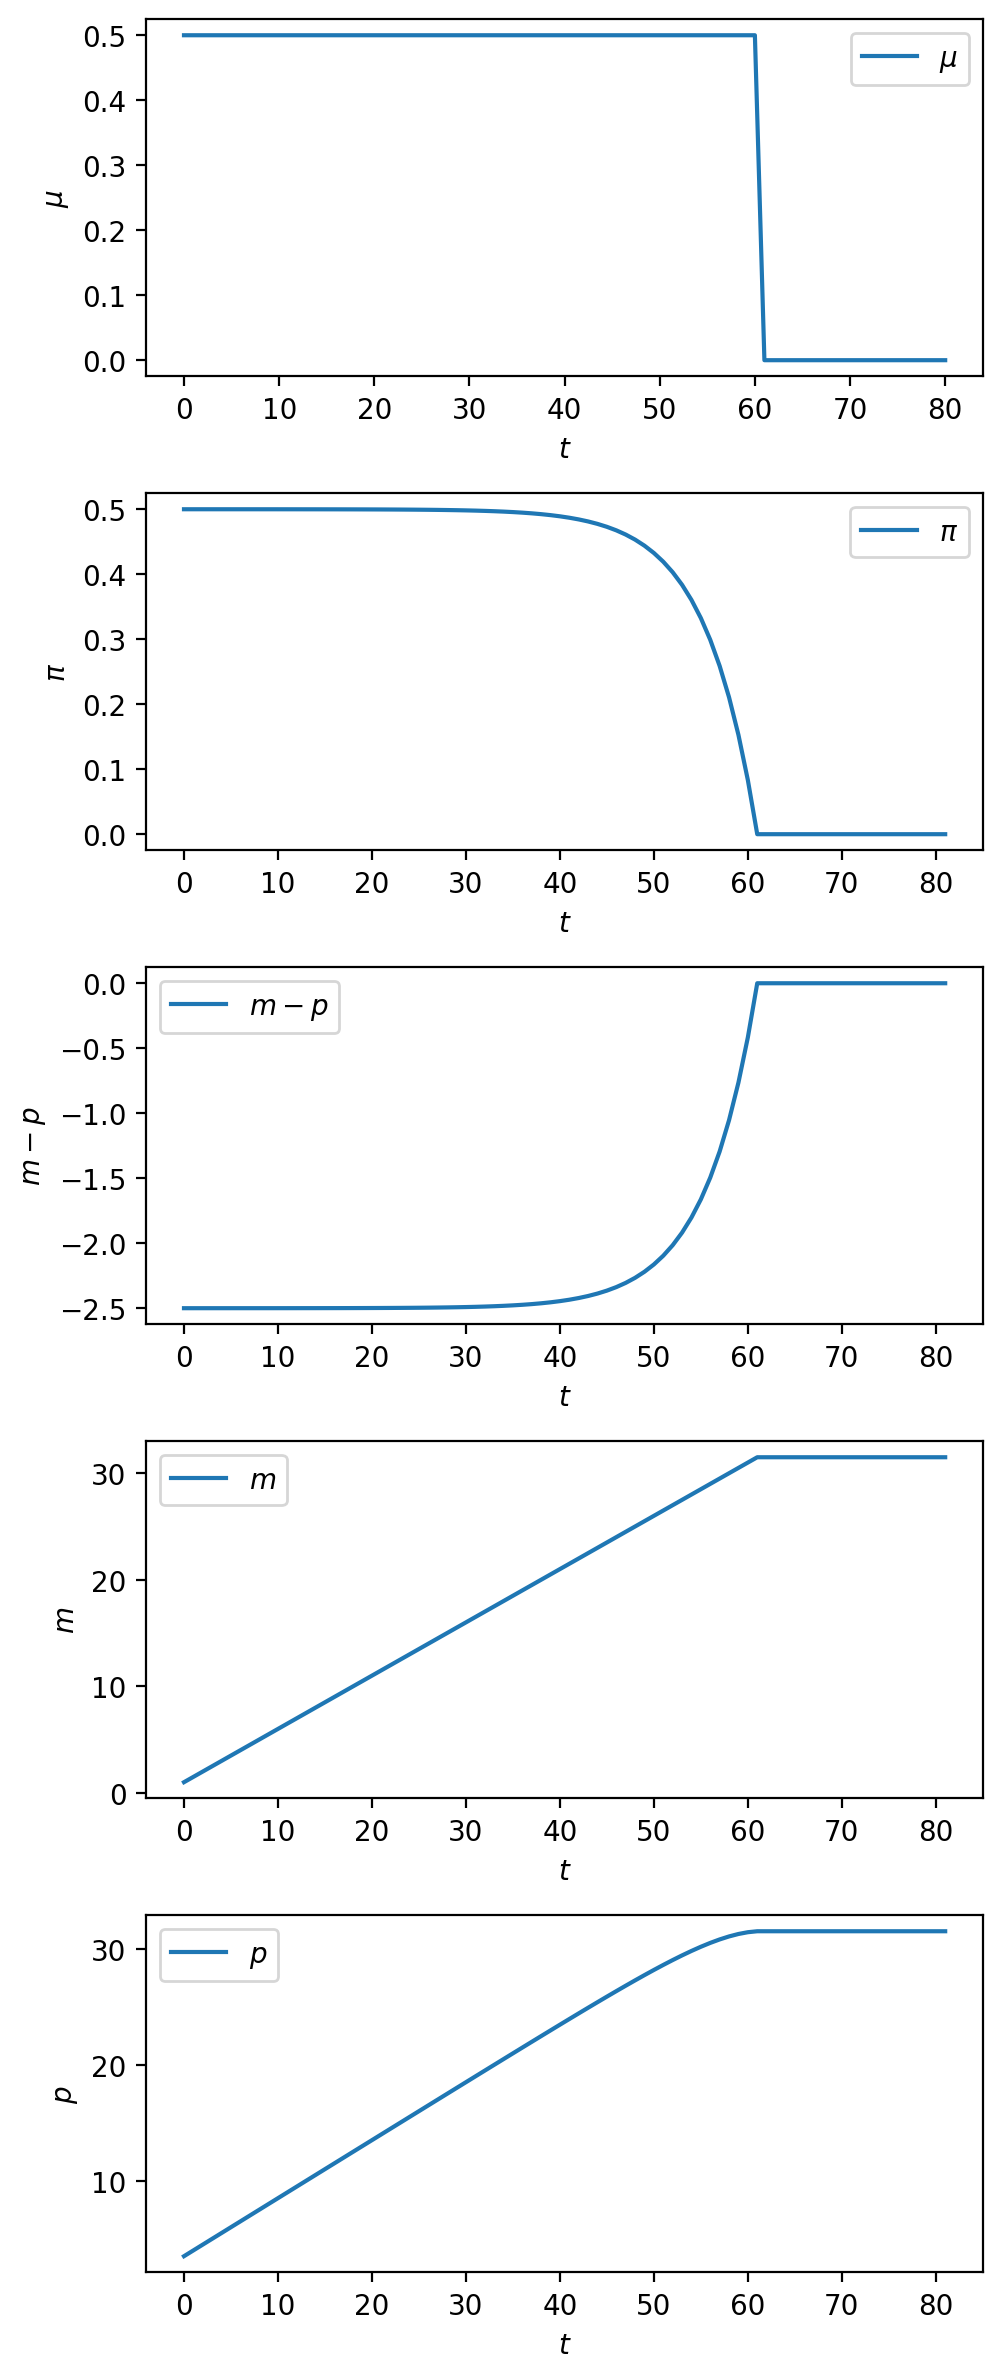

In [5]:
def plot_sequences(sequences, labels):
    fig, axs = plt.subplots(len(sequences), 1, figsize=[5, 12])
    for ax, seq, label in zip(axs, sequences, labels):
        ax.plot(range(len(seq)), seq, label=label)
        ax.set_ylabel(label)
        ax.set_xlabel('$t$')
        ax.legend()
    plt.tight_layout()
    plt.show()

sequences = [μ_seq_1, π_seq_1, m_seq_1 - p_seq_1, m_seq_1, p_seq_1]
plot_sequences(sequences, [r'$\mu$', r'$\pi$', r'$m - p$', r'$m$', r'$p$'])

In [6]:
# path 1
μ_seq_2_path1 = μ0 * np.ones(T+1)

cm1 = create_cagan_model(μ_seq=μ_seq_2_path1)
π_seq_2_path1, m_seq_2_path1, p_seq_2_path1 = solve(cm1, T)

# continuation path
μ_seq_2_cont = μ_star * np.ones(T-T1)

cm2 = create_cagan_model(m0=m_seq_2_path1[T1+1], 
                         μ_seq=μ_seq_2_cont)
π_seq_2_cont, m_seq_2_cont1, p_seq_2_cont1 = solve(cm2, T-1-T1)


# regime 1 - simply glue π_seq, μ_seq
μ_seq_2 = np.concatenate((μ_seq_2_path1[:T1+1],
                          μ_seq_2_cont))
π_seq_2 = np.concatenate((π_seq_2_path1[:T1+1], 
                          π_seq_2_cont))
m_seq_2_regime1 = np.concatenate((m_seq_2_path1[:T1+1], 
                                  m_seq_2_cont1))
p_seq_2_regime1 = np.concatenate((p_seq_2_path1[:T1+1], 
                                  p_seq_2_cont1))

# regime 2 - reset m_T1
m_T1 = (m_seq_2_path1[T1] + μ0) + cm2.α*(μ0 - μ_star)

cm3 = create_cagan_model(m0=m_T1, μ_seq=μ_seq_2_cont)
π_seq_2_cont2, m_seq_2_cont2, p_seq_2_cont2 = solve(cm3, T-1-T1)

m_seq_2_regime2 = np.concatenate((m_seq_2_path1[:T1+1], 
                                  m_seq_2_cont2))
p_seq_2_regime2 = np.concatenate((p_seq_2_path1[:T1+1],
                                  p_seq_2_cont2))

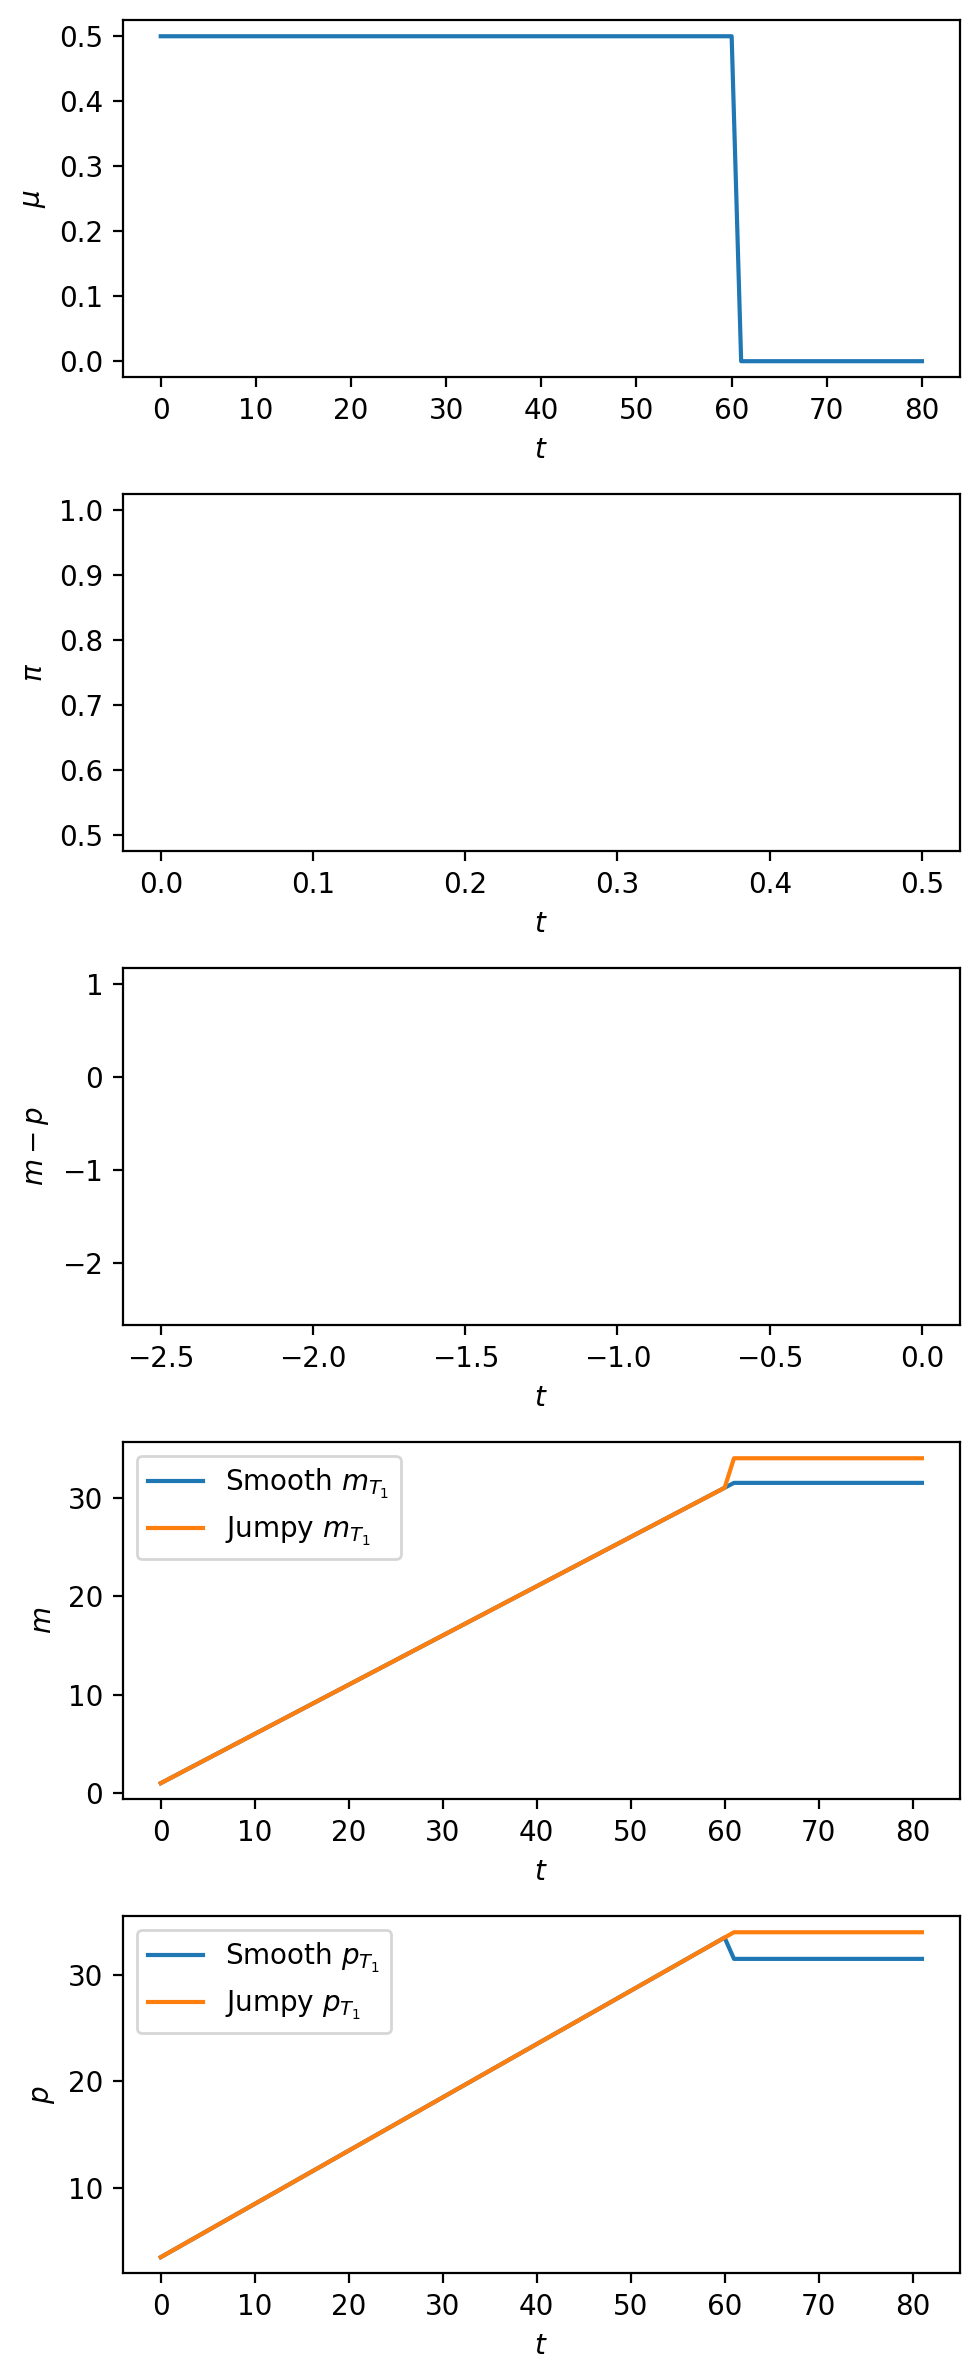

In [7]:
T_seq = range(T+2)

# plot both regimes
fig, ax = plt.subplots(5, 1, figsize=[5, 12])

# Configuration for each subplot
plot_configs = [
    {'data': [(T_seq[:-1], μ_seq_2)], 'ylabel': r'$\mu$'},
    {'data': ((T_seq, π_seq_2)), 'ylabel': r'$\pi$'},
    {'data': ((T_seq, m_seq_2_regime1 - p_seq_2_regime1)), 
     'ylabel': r'$m - p$'},
    {'data': ((T_seq, m_seq_2_regime1, 'Smooth $m_{T_1}$'), 
              (T_seq, m_seq_2_regime2, 'Jumpy $m_{T_1}$')), 
     'ylabel': r'$m$'},
    {'data': ((T_seq, p_seq_2_regime1, 'Smooth $p_{T_1}$'), 
              (T_seq, p_seq_2_regime2, 'Jumpy $p_{T_1}$')), 
     'ylabel': r'$p$'}
]

def experiment_plot(plot_configs, ax):
    # Loop through each subplot configuration
    for axi, config in zip(ax, plot_configs):
        for data in config['data']:
            if len(data) == 3:  # Plot with label for legend
                axi.plot(data[0], data[1], label=data[2])
                axi.legend()
            else:  # Plot without label
                axi.plot(data[0], data[1])
        axi.set_ylabel(config['ylabel'])
        axi.set_xlabel(r'$t$')
    plt.tight_layout()
    plt.show()
    
experiment_plot(plot_configs, ax)

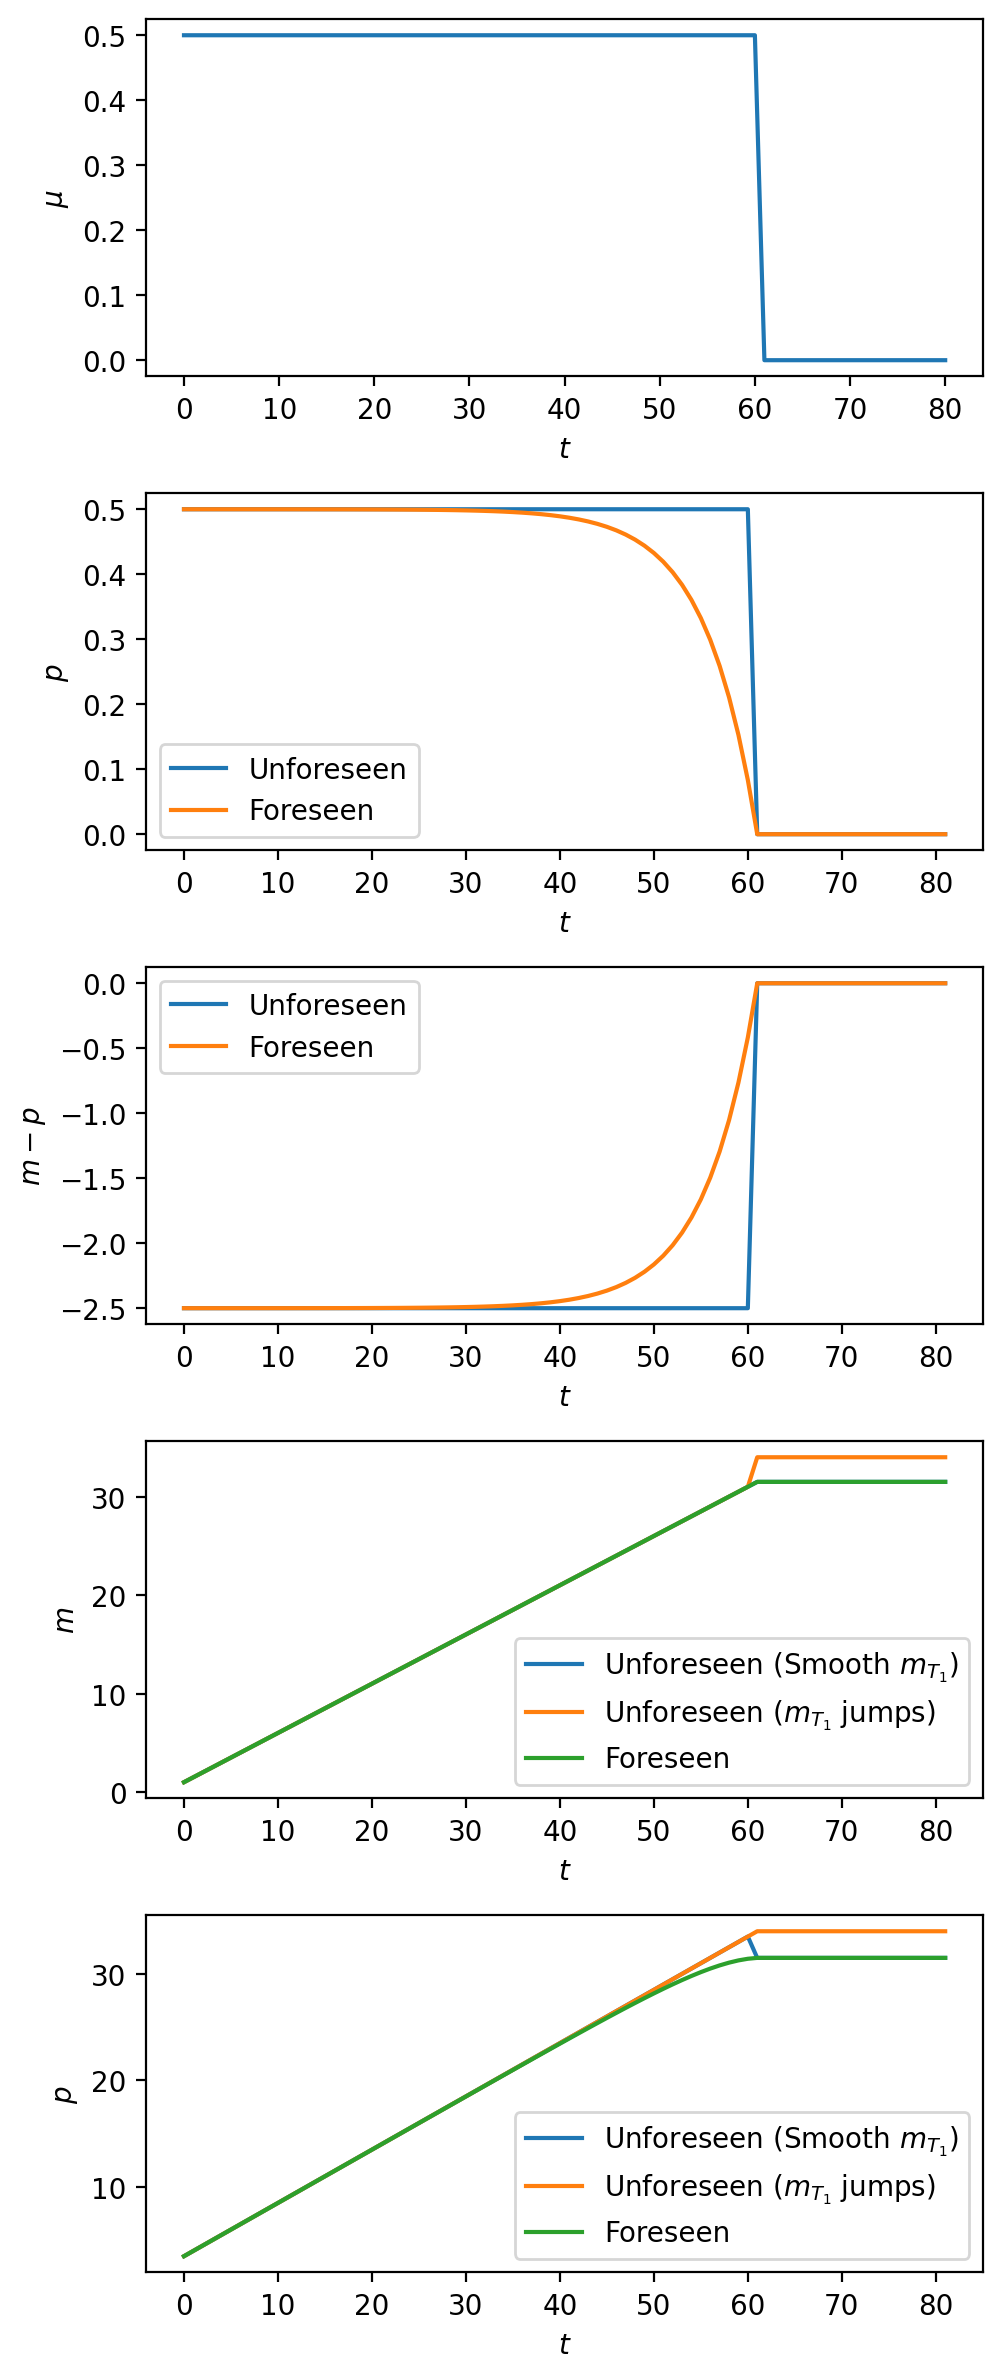

In [8]:
# compare foreseen vs unforeseen shock
fig, ax = plt.subplots(5, figsize=[5, 12])

plot_configs = [
    {'data': [(T_seq[:-1], μ_seq_2)], 'ylabel': r'$\mu$'},
    {'data': [(T_seq, π_seq_2, 'Unforeseen'), 
              (T_seq, π_seq_1, 'Foreseen')], 'ylabel': r'$p$'},
    {'data': [(T_seq, m_seq_2_regime1 - p_seq_2_regime1, 'Unforeseen'), 
              (T_seq, m_seq_1 - p_seq_1, 'Foreseen')], 'ylabel': r'$m - p$'},
    {'data': [(T_seq, m_seq_2_regime1, 'Unforeseen (Smooth $m_{T_1}$)'), 
              (T_seq, m_seq_2_regime2, 'Unforeseen ($m_{T_1}$ jumps)'),
              (T_seq, m_seq_1, 'Foreseen')], 'ylabel': r'$m$'},   
    {'data': [(T_seq, p_seq_2_regime1, 'Unforeseen (Smooth $m_{T_1}$)'), 
          (T_seq, p_seq_2_regime2, 'Unforeseen ($m_{T_1}$ jumps)'),
          (T_seq, p_seq_1, 'Foreseen')], 'ylabel': r'$p$'}   
]

experiment_plot(plot_configs, ax)

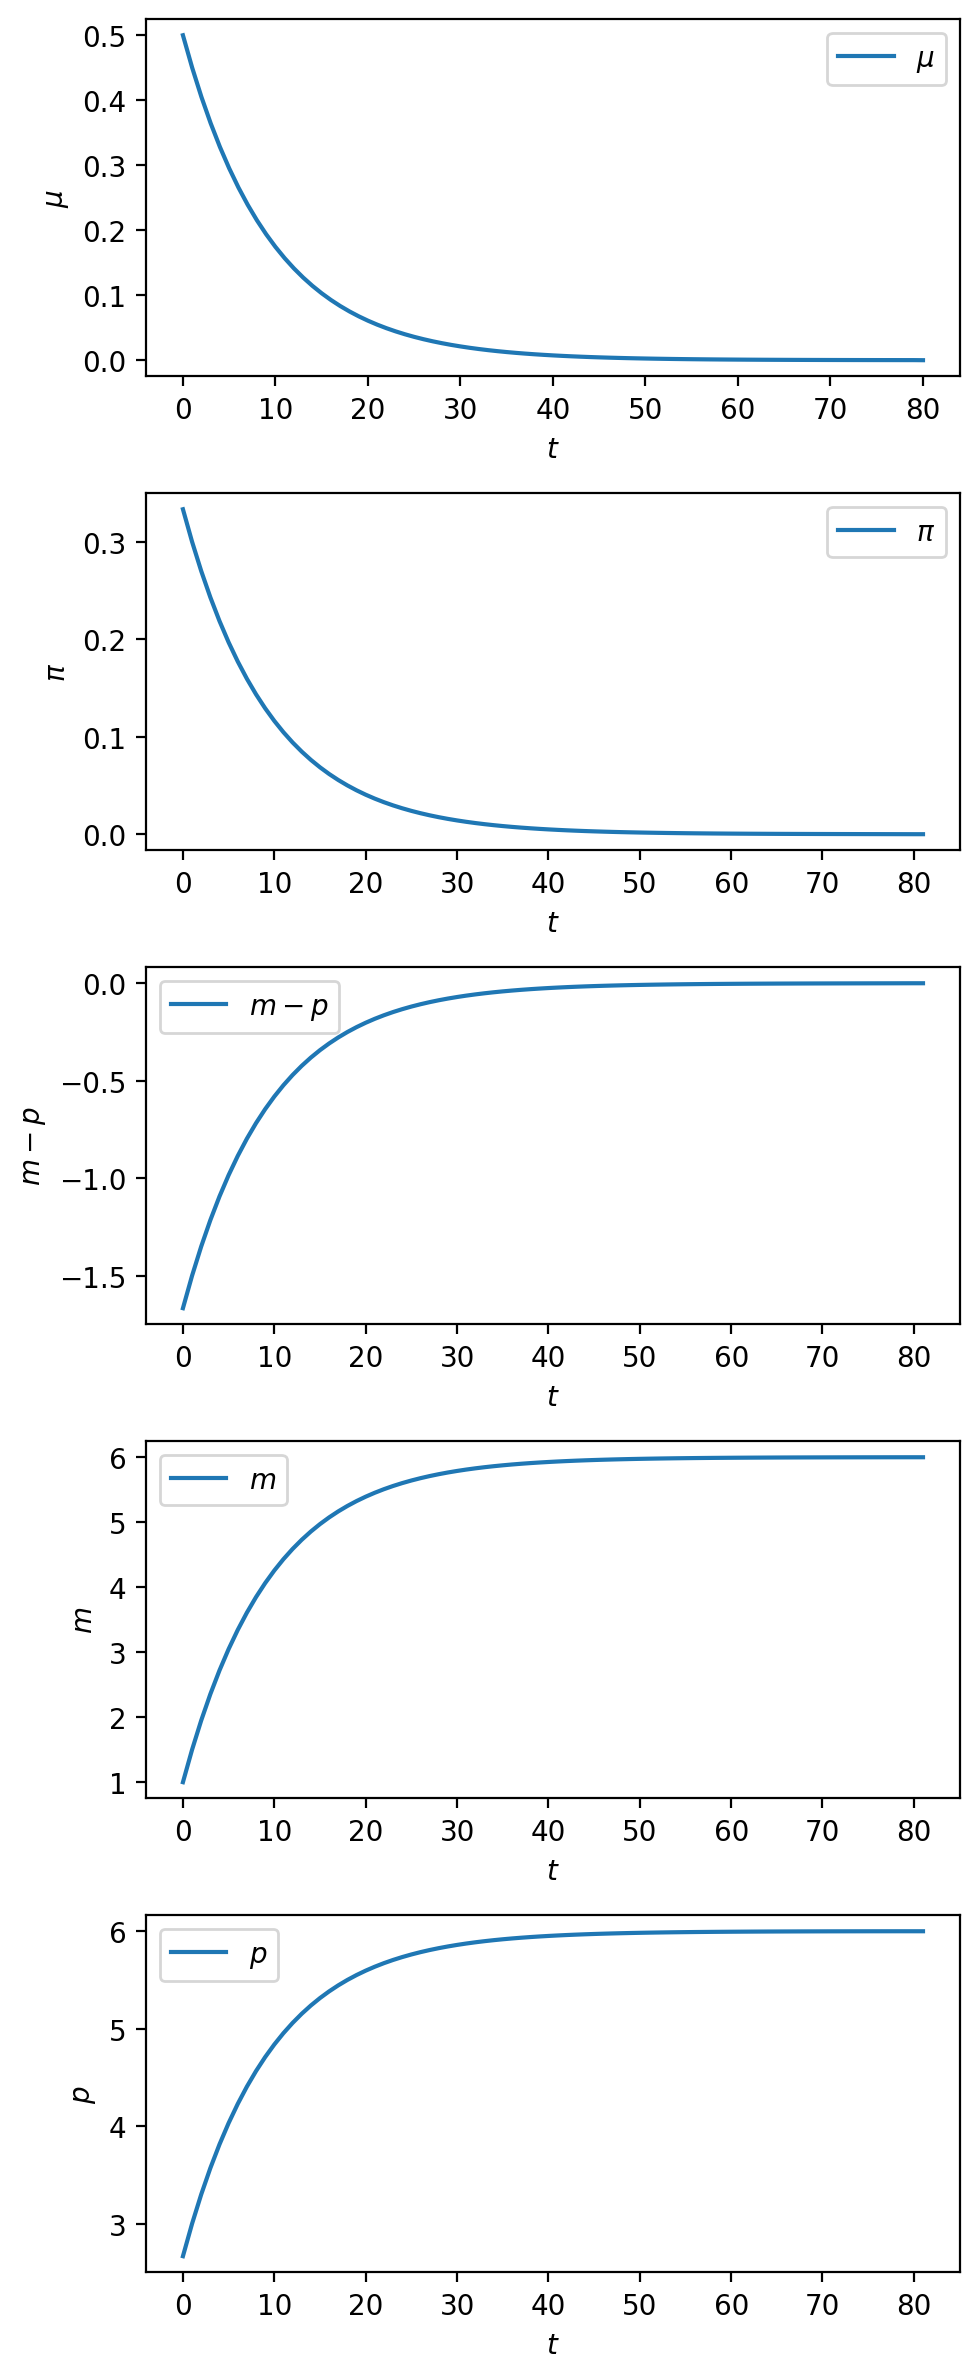

In [9]:
# parameters
ϕ = 0.9
μ_seq_stab = np.array([ϕ**t * μ0 + (1-ϕ**t)*μ_star for t in range(T)])
μ_seq_stab = np.append(μ_seq_stab, μ_star)

cm4 = create_cagan_model(μ_seq=μ_seq_stab)

π_seq_4, m_seq_4, p_seq_4 = solve(cm4, T)

sequences = [μ_seq_stab, π_seq_4, 
             m_seq_4 - p_seq_4, m_seq_4, p_seq_4]
plot_sequences(sequences, [r'$\mu$', r'$\pi$', 
                           r'$m - p$', r'$m$', r'$p$'])